In [1]:
import numpy as np
import pandas as pd
import rpy2
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display_html
from IPython.display import display
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline; border:0px"')          
    display_html(html_str,raw=True)

In [2]:
# R magic using rpy2!
%load_ext rpy2.ipython

## Simple AR series

Simulata data from
$$Y_t = ct + \phi Y_{t-1} + \epsilon_t$$


with $c=0.2$, $\phi=0.9$ and $\epsilon_t$ being white noise.

https://stats.stackexchange.com/questions/294600/how-can-i-simulate-with-arima-sim-drift-intercept-and-trend

In [3]:
%%R -o ar_sim
set.seed(5)
model = list(order=c(1,0,0),ar=c(.9))
n = 100
c = 0.02

ar_sim = as.data.frame(arima.sim(model=model, n=n))
ar_sim = ar_sim + c*seq(1,n)

C:\Anaconda\envs\dev\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


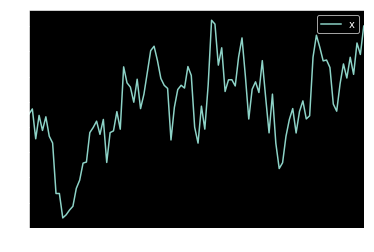

In [4]:
ar_sim.plot()

## f: Point estimates vs. probabilistic forecasts

Simulata data from
$$Y_t = \phi Y_{t-1} + \epsilon_t$$

with $\phi=0.9$ and $\epsilon_t$ being white noise.

[arima.sim](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/arima.sim.html)<br>
[simulate](https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/simulate)<br>
[arima](https://www.rdocumentation.org/packages/stats/versions/3.1.1/topics/arima)<br>
[forecast](https://cran.r-project.org/web/packages/forecast/forecast.pdf)<br>
[The difference between prediction intervals and confidence intervals](https://robjhyndman.com/hyndsight/intervals/)<br>

In [5]:
%%R
require(forecast)

In [6]:
%%R -o model_forecast,model,data_oos

n_insample = 100
n_forecast = 20
n_forcpaths = 50

set.seed(1337)

# https://robjhyndman.com/hyndsight/simulating-from-a-specified-seasonal-arima-model/
# Package forecast is designed to to simulate from a fitted model rather 
# than a user-specified model. Following is a hack to simulate from user specified model:

# First "fit" a model with random data and fix parameters using argument "fixed"
model_dummy = Arima(ts(rnorm(n_insample),freq=1), order=c(1,0,0),fixed=c(0.9,0))
# Simulate a series from this model
data_ins = as.data.frame(simulate(model_dummy,n=n_insample))

# Now construct a new model with original data from previous simulation
# and again fix the parameters
model = Arima(ts(data_ins,freq=1), order=c(1,0,0),fixed=c(0.9,0))

# Now we can forecast using the model
model_forecast = model %>% forecast(h=n_forecast, level=0.95)

# Simulate forwards paths
data_oos = as.data.frame(replicate(n_forcpaths,simulate(model,nsim=n_forecast)))

C:\Anaconda\envs\dev\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,original,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V45,V46,V47,V48,V49,V50,lower,upper,mean,original_cnnct
0,1.142258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142258
1,0.438602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.438602
2,2.494769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.494769


,original,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V45,V46,V47,V48,V49,V50,lower,upper,mean,original_cnnct
117,NaN,-7.220359,1.738016,0.890094,-3.082229,1.094720,2.762902,1.414799,-5.861051,5.526285,...,-3.573937,-0.982567,7.823387,0.254277,3.495877,4.165381,-5.986156,7.798008,0.905926,NaN
118,NaN,-5.929482,5.064968,1.197651,-6.263743,1.698055,3.594558,0.234739,-7.720031,5.425130,...,-2.551258,2.248332,5.091105,0.203120,5.098786,1.606865,-6.091822,7.722489,0.815333,NaN
119,NaN,-6.616864,2.952996,0.274505,-4.649510,2.417811,4.246103,-1.260941,-5.329077,4.880374,...,-2.578327,5.382506,3.206328,0.589569,4.585582,-0.416028,-6.185541,7.653141,0.733800,NaN


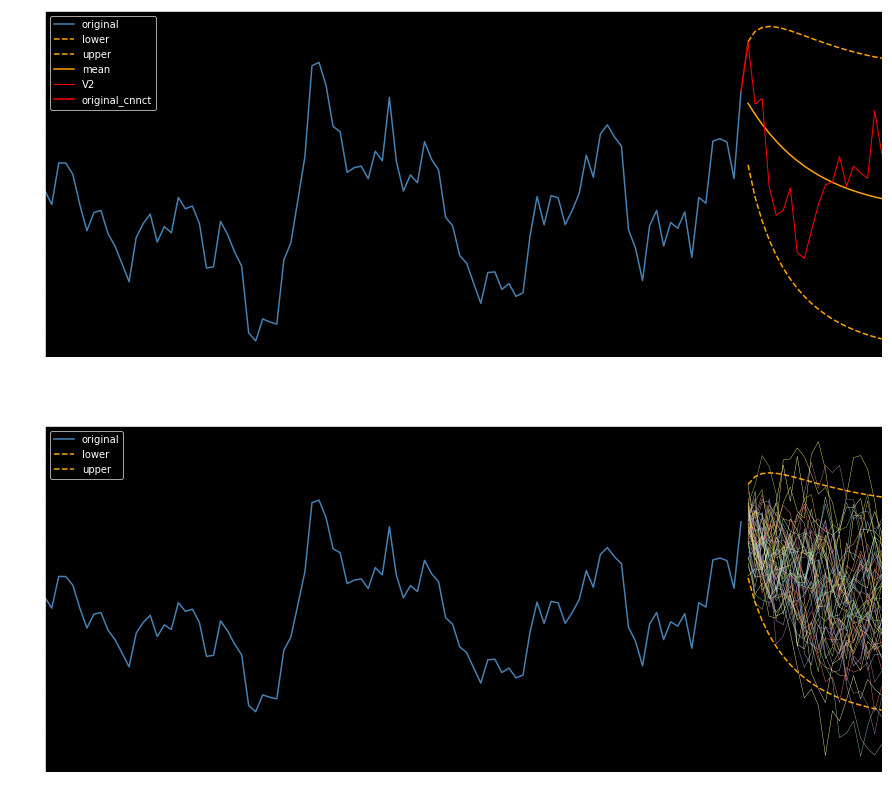

In [7]:
chosen_fw_path = 'V2'

df_orig = pd.DataFrame(np.array(model_forecast.rx('x')[0]).flatten(), columns=['original'])
#df_orig['innovations'] = np.array(model_forecast.rx('residuals')[0]).flatten()

df_forecast = data_oos.copy()
df_forecast['lower'] = np.array(model_forecast.rx('lower')[0]).flatten()
df_forecast['upper'] = np.array(model_forecast.rx('upper')[0]).flatten()
df_forecast['mean'] = np.array(model_forecast.rx('mean')[0]).flatten()

df_forecast.index = range(len(df_orig),len(df_orig) + len(df_forecast))
df = df_orig.append(df_forecast, ignore_index=True, sort=False)

# Connect original to given forecast
df['original_cnnct'] = df['original']
df.loc[len(df_orig),'original_cnnct'] = df.loc[len(df_orig),chosen_fw_path]

fig = plt.figure(figsize=(15,14))
ax1 = fig.add_subplot(211)
df[['original']].plot(ax=ax1,c='steelblue')
df[['lower','upper']].plot(ax=ax1,c='orange',style='--')
df[['mean']].plot(ax=ax1,c='orange')
df[[chosen_fw_path]].plot(ax=ax1,c='red', lw=1)
df.loc[len(df_orig)-1:len(df_orig),['original_cnnct']].plot(ax=ax1,c='red')

ax2 = fig.add_subplot(212)
df[['original']].plot(ax=ax2,c='steelblue')
df[['lower','upper']].plot(ax=ax2,c='orange',style='--')
cols = [el for el in df.columns if el not in ['mean','lower','upper','original','original_cnnct']]
df[cols].plot(ax=ax2, lw=0.4, legend=False)

display(df.head(3))
display(df.tail(3))

## d: Over and underfit

Inspired by example found here:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

### Easy polynominal + linear regression example
From here: https://stats.stackexchange.com/questions/58739/polynomial-regression-using-scikit-learn

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [77]:
# In-sample data with two features
data = pd.DataFrame({"x1":[0.44, 0.99], "x2":[0.68, 0.23], "y":[109.85, 155.72]})
display(data)

# OOS data
predict = pd.DataFrame({"x1_pred": [0.49], "x2_pred":[0.18]})
display(predict)

# Expand in-sample features into second polynominal (bias term added as well)
poly = PolynomialFeatures(degree=2)
X = data[['x1', 'x2']].copy().values
X_ = poly.fit_transform(X)

X__df = pd.DataFrame(X_)
X__df.columns = ['1', 'x1', 'x2', 'x1x2', 'x1^2', 'x2^2']
display(X__df)

# Expand OOS features similarly
pred = predict.copy().values
pred_ = poly.fit_transform(pred)

pred__df = pd.DataFrame(pred_)
pred__df.columns = ['1', 'x1', 'x2', 'x1x2', 'x1^2', 'x2^2']
display(pred__df)

# Fit linear regression on expanded data
y_df = data['y'].copy().values
clf = LinearRegression()
clf.fit(X_, y)

# Preditc OOS y
pred__df['y'] = clf.predict(pred_)
pred__df

,x1,x2,y
0,0.44,0.68,109.85
1,0.99,0.23,155.72


,x1_pred,x2_pred
0,0.49,0.18


,1,x1,x2,x1x2,x1^2,x2^2
0,1.0,0.44,0.68,0.1936,0.2992,0.4624
1,1.0,0.99,0.23,0.9801,0.2277,0.0529


,1,x1,x2,x1x2,x1^2,x2^2
0,1.0,0.49,0.18,0.2401,0.0882,0.0324


,1,x1,x2,x1x2,x1^2,x2^2,y
0,1.0,0.49,0.18,0.2401,0.0882,0.0324,126.842471


### Actual data for this example
https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html